<a href="https://colab.research.google.com/github/FernandaSantos225/da-ebac/blob/main/M41_Exercicio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Big Data II - Armazenamento
Caderno de **Exercícios**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>Introdução;</li>
  <li>Orientação a coluna;</li>
  <li>Particionamento.</li>
</ol>

---

# **Exercícios**

## 1\. Particionamento e orientação a coluna.

Replique as atividades da aula 3 em sua conta da AWS.

1.1. Faça o download do arquivo `crime.csv` (fonte [Kaggle](https://www.kaggle.com/yamqwe/chicago-crimee?select=chicago_crime_2014.csv)).

In [1]:
!wget https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/crime.csv -q -O crime.csv

1.2. Leia os dados em um DataFrame Pandas e crie a coluna `reference_date`.

In [2]:
import pandas as pd
from datetime import datetime as dt

crimes_df = pd.read_csv('crime.csv')
crimes_df.head(2)

,index,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Latitude,Longitude
0,0,9446824,HX100141,01/01/2014 02:00:00 AM,0000X W ILLINOIS ST,0460,BATTERY,SIMPLE,STREET,False,False,1831,18,42.0,8.0,08B,41.890828,-87.630235
1,1,9446748,HX100020,01/01/2014 12:00:00 AM,006XX N DEARBORN ST,0890,THEFT,FROM BUILDING,BAR OR TAVERN,False,False,1832,18,42.0,8.0,06,41.893542,-87.629702


In [3]:
data_ex = crimes_df['Date'].loc[0]
data_ex

'01/01/2014 02:00:00 AM'

In [4]:
dt.strptime(data_ex.split(sep=' ')[0], '%m/%d/%Y').strftime('%Y-%m-%d')

'2014-01-01'

In [5]:
crimes_df['reference_date'] = crimes_df['Date'].apply(
    lambda data: dt.strptime(data.split(sep=' ')[0],  '%m/%d/%Y').strftime('%Y-%m-%d')
)

In [6]:
crimes_df[['reference_date']].tail()

,reference_date
274418,2014-08-15
274419,2014-08-31
274420,2014-02-20
274421,2014-09-02
274422,2014-12-04


1.3. Persista o dado no DataFrame em um arquivo csv e em arquivos parquet, estes últimos comprimidos e particionados pela coluna `reference_date`.

In [7]:
# salvando em csv:
crimes_df.to_csv(
    'crime_enriched.csv',
    sep=',',
    index=False
)

# salvando em parquet:
crimes_df.to_parquet(
    './crimes',
    engine = 'pyarrow',
    compression = 'gzip',
    partition_cols = 'reference_date'
)

1.4. Crie os recursos no AWS S3 e AWS IAM e persista os dados em seus respectivos *buckets*.

**Usuário programático IAM**

In [ ]:
from getpass import getpass

aws_access_key_id = getpass()
aws_secret_access_key = getpass()

In [ ]:
!pip install -q boto3

In [ ]:
import boto3

client = boto3.client(
  's3',
  aws_access_key_id=aws_access_key_id,
  aws_secret_access_key=aws_secret_access_key
)

In [ ]:
import os

BUCKET = 'bucket-42-parquet'

i = 0

for root, dirs, files in os.walk('./crimes'):
  elapsed = f'{round(100*i/365, 2)} %'
  print(elapsed)
  for file in files:
    path = os.path.join(root, file)
    bucket_path = '/'.join(path.split(sep='/')[2:])
    client.upload_file(path, BUCKET, bucket_path)
  i = i + 1


1.5. Crie os recursos no AWS Athena e execute as consultas SQL da aula.

```sql
--Q1 CSV
SELECT "location description", COUNT(1) as "amount"
FROM crime_csv
GROUP BY 1
ORDER BY 2 DESC;

--Q1 PARQUET
SELECT "location description", COUNT(1) as "amount"
FROM crime_parquet
GROUP BY 1
ORDER BY 2 DESC;

--Q2 CSV:
SELECT *
FROM crime_csv
WHERE CAST(reference_date as DATE) BETWEEN DATE '2014-12-01' and DATE '2014-12-31'

--Q2 PARQUET
SELECT *
FROM crime_parquet
WHERE CAST(reference_date as DATE) BETWEEN DATE '2014-12-01' and DATE '2014-12-31'

--Q3 CSV:
SELECT "location description", COUNT(1) as "amount"
FROM crime_csv
WHERE CAST(reference_date as DATE) BETWEEN DATE '2014-12-01' and DATE '2014-12-31'
GROUP BY 1
ORDER BY 2 DESC

--Q3 PARQUET:
SELECT "location description", COUNT(1) as "amount"
FROM crime_parquet
WHERE CAST(reference_date as DATE) BETWEEN DATE '2014-12-01' and DATE '2014-12-31'
GROUP BY 1
ORDER BY 2 DESC
```

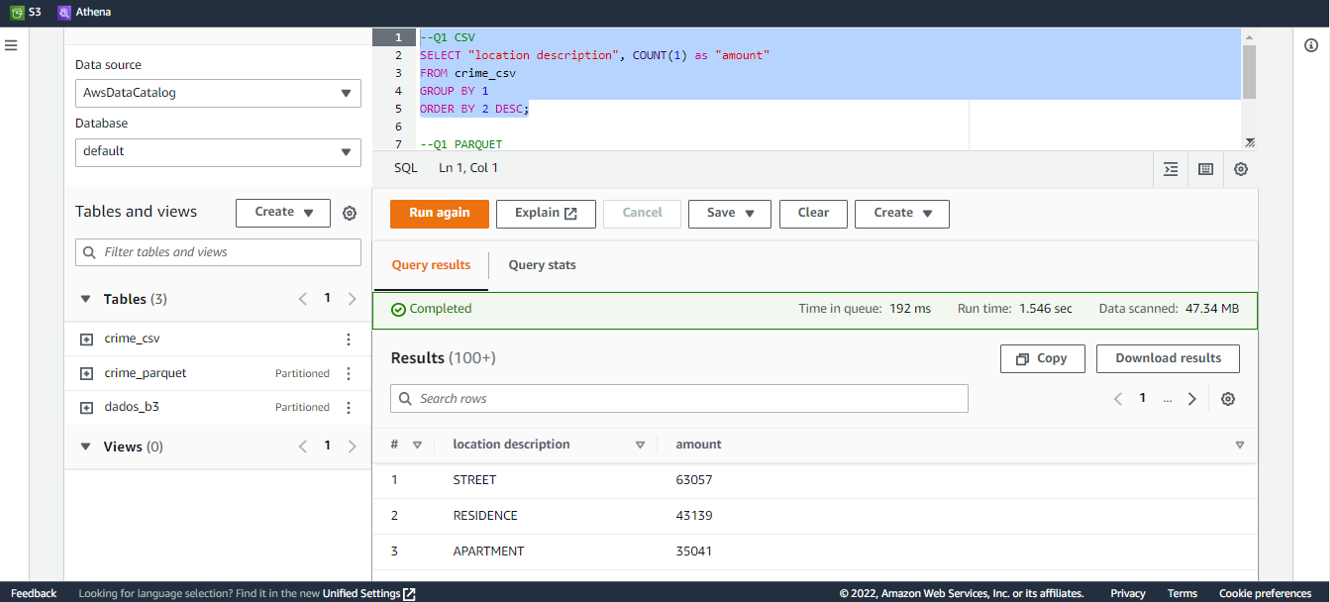

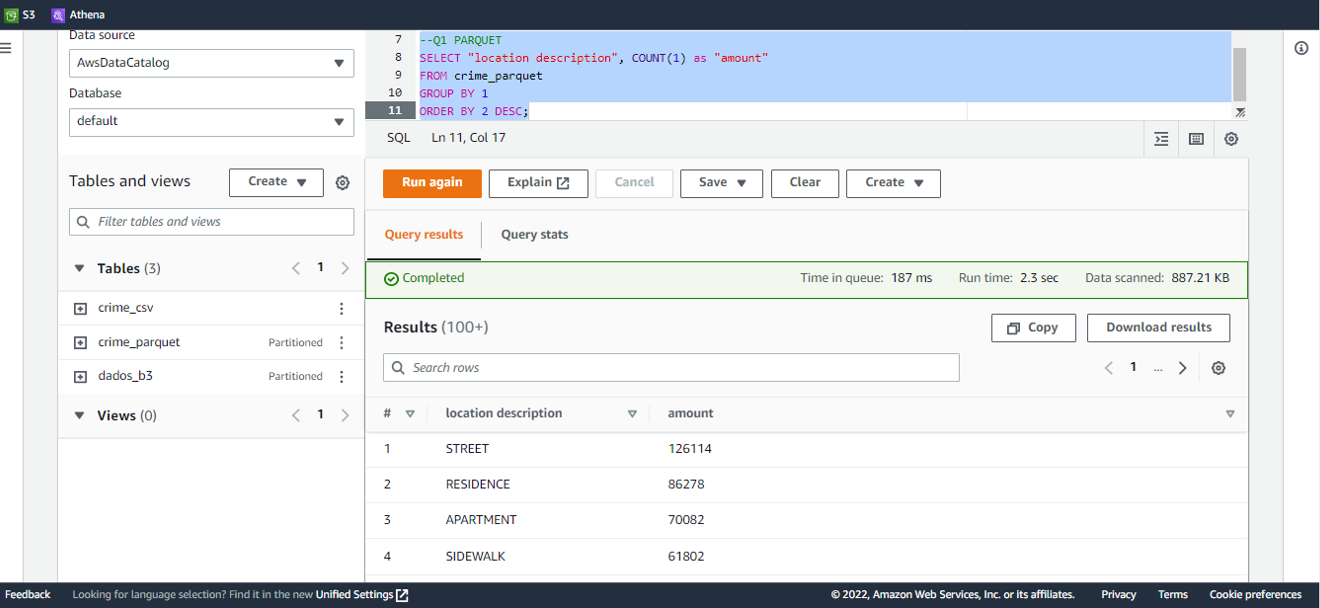

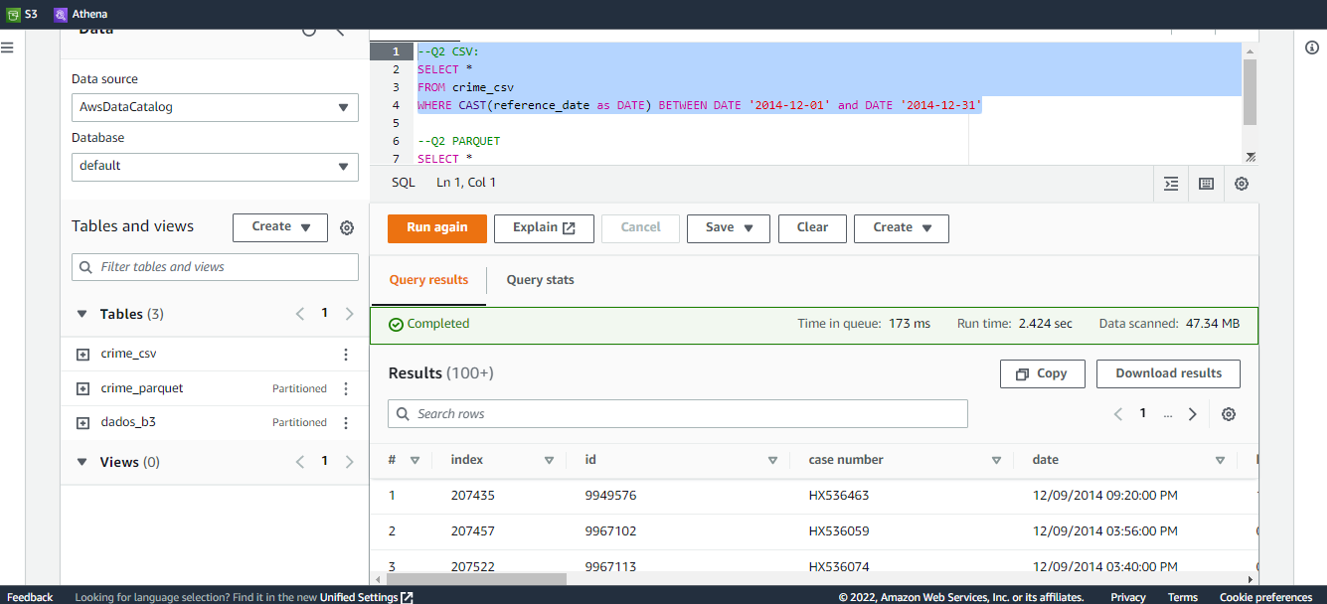

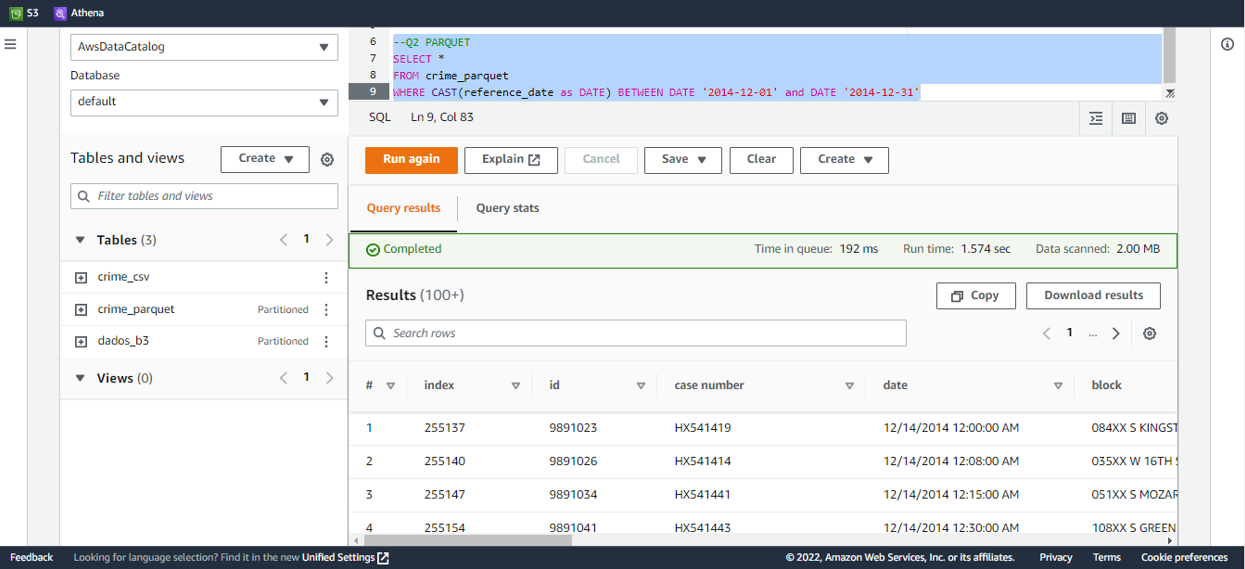

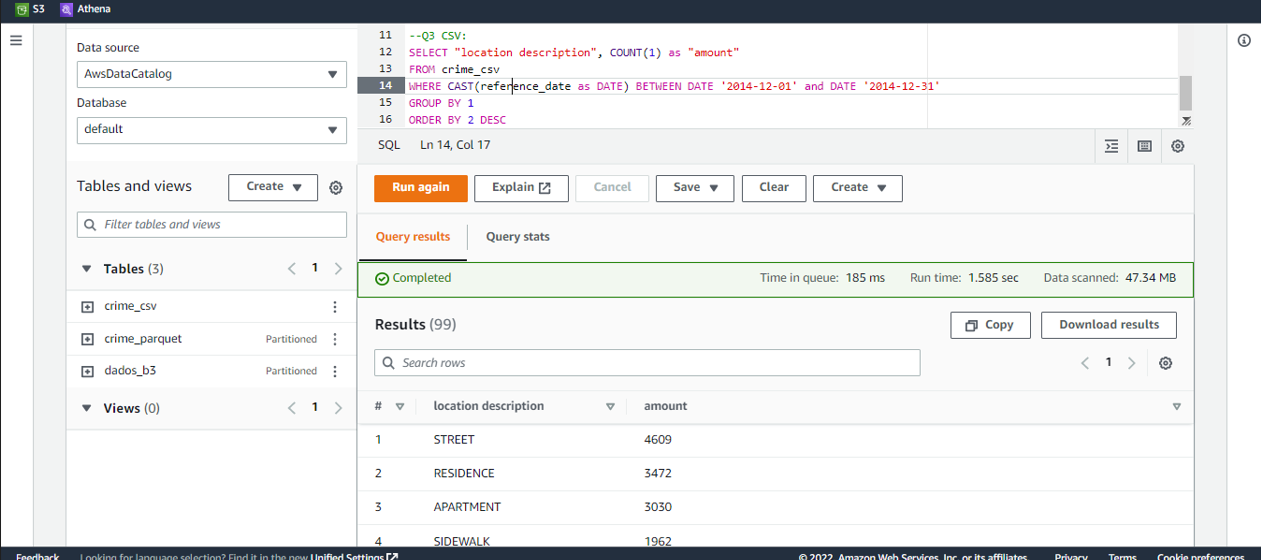

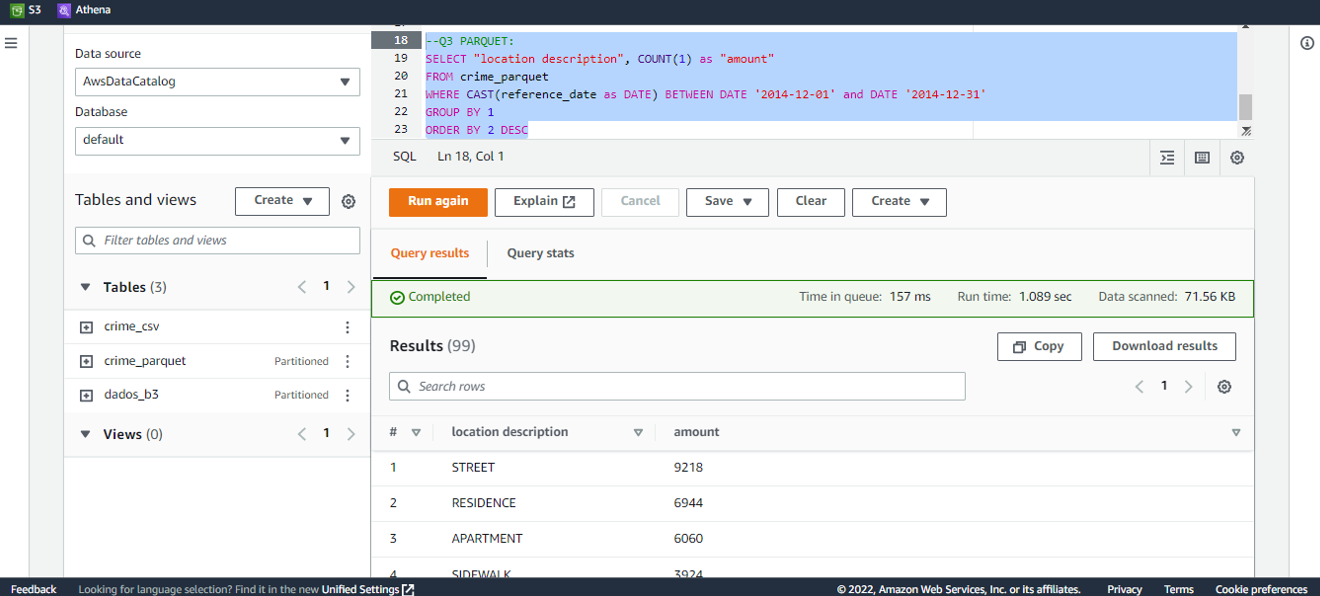